## Installare le librerie necessarie

*mne => Open-source Python package for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, NIRS, and more.(https://mne.tools/stable/index.html)*

*Braindecode is an open-source Python toolbox for decoding raw electrophysiological brain data with deep learning models (https://braindecode.org/stable/index.html).*

In [ ]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 99.7 MB/s eta 0:00:00


In [ ]:
pip install braindecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 35.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


======================================================

## EEG Classification Pipeline: Data Prep, Training & Test

======================================================

In [ ]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.model_selection import train_test_split
from braindecode.models import EEGNet
import seaborn as sns
from sklearn.metrics import confusion_matrix

## 1. Caricamento e processamento dei dati

In [ ]:
## montare google drive su colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_path = "/content/drive/MyDrive/derivatives/" # path alla cartella dove sono contenuti i dati EEG raw

In [ ]:
#iteriamo sui dati grezzi (raw EEG) dei soggetti

total_data_raw = []

for i in range(1,55): # 55 perchè di più google colab non riesce a gestirli

    subject = f"sub-{i:03d}"
    subject_file = os.path.join(base_path, subject, "eeg", f"{subject}_task-eyesclosed_eeg.set")
    if os.path.exists(subject_file):
        raw = mne.io.read_raw_eeglab(subject_file, preload=True)
        total_data_raw.append(raw)
    else:
        print(f"File non trovato: {subject_file}")

Using matplotlib as 2D backend.


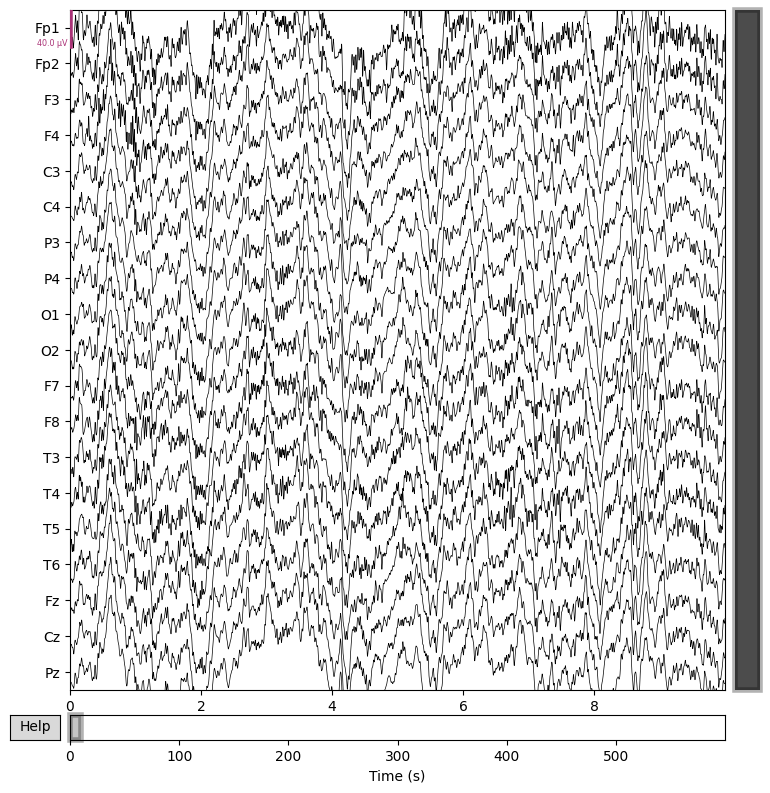

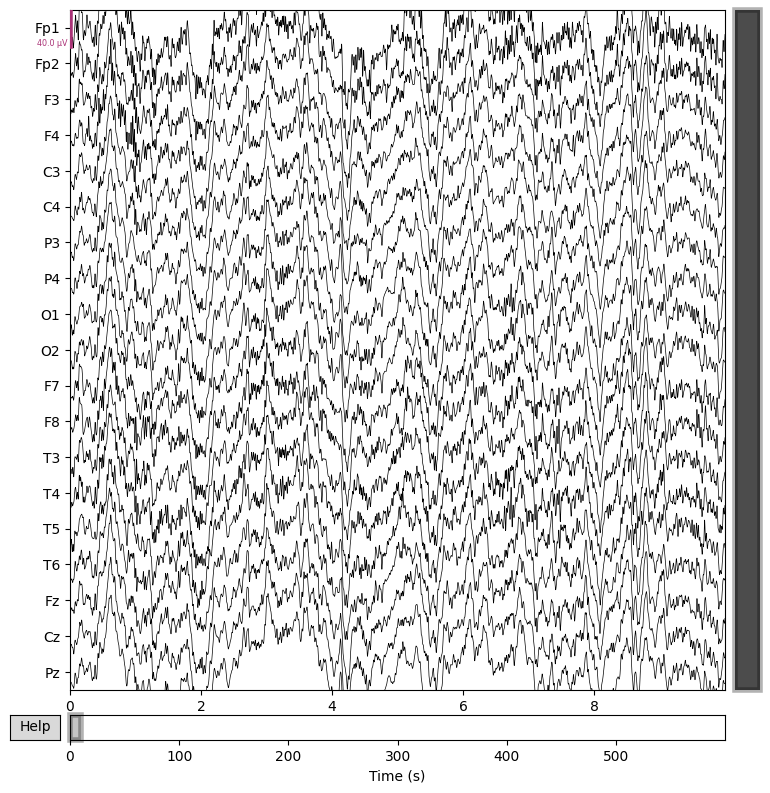

In [ ]:
# plot segnale EEG

total_data_raw[0].plot()

In [ ]:
dataset_path = "/content/drive/MyDrive/participants.xlsx" # path al dataset contenente dati demografici e clinici
dataset = pd.read_excel(dataset_path)
labels = dataset["Group"].iloc[:54] # prendiamo solo le prime 55
label_map = {"A":0, "C":1, "F":2} # A=> Alzheimer, C => Controllo, F => Frontotemporal dementia

In [ ]:
X_all = []
y_all = []

subject_ids = []

# Iteriamo su tutti i dati grezzi (raw EEG) dei soggetti

for i, raw in enumerate(total_data_raw):

    # dividiamo il segnale EEG in epoche consecutive di lunghezza pari a 2s
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0, preload=True)
    X = epochs.get_data()  # => (n_epochs, n_channels, n_times)
    # (numero di epoche estratte dal segnale EEG, numero di canali, numero di campioni temporali per ogni epoca)

    # Normalizziamo le epoche per ogni canale
    # In questo modo media = 0 e std = 1 lungo l'asse temporale
    X = (X - X.mean(axis=-1, keepdims=True)) / X.std(axis=-1, keepdims=True)

    # Assegniamo la stessa label a tutte le epoche del soggetto
    # np.full => Return a new array of given shape and type, filled with fill_value.
    y = np.full(len(X), fill_value=label_map[labels[i]])

    # Memorizziamo l'ID del soggetto per ogni epoca
    subject_ids.extend([i] * len(X))

    # Aggiungiamo le epoche e le etichette alla lista totale
    X_all.append(X)
    y_all.append(y)


# Concateniamo verticalmente tutti i soggetti per epoca

X_all = np.vstack(X_all)

y_all = np.hstack(y_all)

Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 299 events and 1000 original time points ...
0 bad epochs dropped
Not setting metadata
396 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 396 events and 1000 original time points ...
0 bad epochs dropped
Not setting metadata
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 1000 original time points ...
0 bad epochs dropped
Not setting metadata
353 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 353 events and 1000 original time points ...
0 bad epochs dropped
Not setting metadata
402 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 402 events and 1000 original ti

## 2. Split in train/val/test set

In [ ]:
# labels per soggetto

subject_labels = np.array([label_map[l] for l in labels]) # facciamo il mapping di tutte le labels
subject_ids_unique = np.arange(len(subject_labels))

# splitto gli ID dei soggetti in trainval e test (20% test)
trainval_subj, test_subj = train_test_split(
    subject_ids_unique,
    test_size=0.2,
    random_state=42,
    stratify=subject_labels # mantenere la stessa proporzione delle classi
)

# splitto gli ID dei soggeti in trainval ulteriormente in train e val (30% val)
train_subj, val_subj = train_test_split(
    trainval_subj,
    test_size=0.3,
    random_state=42,
    stratify=subject_labels[trainval_subj] # mantenere la stessa proporzione delle classi
)

# Associamo le epoche ai soggetti tramite maschere booleane
# Importante: tutte le epoche di un soggetto devono stare nello stesso split per evitare DATA LEAKAGE
train_idx = np.isin(subject_ids, train_subj)
val_idx   = np.isin(subject_ids, val_subj)
test_idx  = np.isin(subject_ids, test_subj)

# Convertiamo in tensori pytorch
X_train = torch.tensor(X_all[train_idx], dtype=torch.float32)
y_train = torch.tensor(y_all[train_idx], dtype=torch.long) # per classificazione torch.long

X_val = torch.tensor(X_all[val_idx], dtype=torch.float32)
y_val = torch.tensor(y_all[val_idx], dtype=torch.long)

X_test = torch.tensor(X_all[test_idx], dtype=torch.float32)
y_test = torch.tensor(y_all[test_idx], dtype=torch.long)

In [ ]:
# Filtriamo per mantenere solo classe 0 e 1, quindi Alzheimer e controllo

train_mask = (y_train != 2)
val_mask   = (y_val != 2)
test_mask  = (y_test != 2)

X_train_bin = X_train[train_mask]
y_train_bin = y_train[train_mask]

X_val_bin   = X_val[val_mask]
y_val_bin   = y_val[val_mask]

X_test_bin  = X_test[test_mask]
y_test_bin  = y_test[test_mask]

## 3. Model SETUP

In [ ]:
n_classes = 2   # A, C
n_channels = X_all.shape[1]
n_times = X_all.shape[2]

# inizializziamo il modello EEGNet
model = EEGNet(
    n_chans=n_channels,
    n_outputs=n_classes, # numero di predizioni del modello EEGNet
    n_times=n_times
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Calcoliamo pesi delle classi per gestire dataset sbilanciati (più A che C)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.numpy()),
    y=y_train.numpy() # restituisce un tensore come un array numpy
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

class_weights = 'balanced' => calcola il peso delle classi secondo questa formula:

$$
\frac{n\_samples}{n\_classes \cdot \text{np.bincount}(y)}
$$

- n_samples = numero totale di campioni nel dataset

- n_classes = numero totale di classi

- np.bincount(y) = array che conta quanti campioni ci sono per ogni classe(es. per y = [0,0,0,1,1] → bincount = [3, 2])

In [ ]:
class_weights

tensor([0.7596, 1.4631], device='cuda:0')

## 4. Creiamo Dataset e Dataloader

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val, y_val)
test_dataset  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 5. Loss, optimizer and scheduler

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights) # Loss ponderata
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
optimizer, mode='min', factor=0.5, patience=5
)

num_epochs = 50
best_val_loss = np.inf
patience_counter = 0
patience = 7

train_losses = []
val_losses = []
val_accuracies = []

## 6. Training + Validation Loop

In [ ]:
for epoch in range(num_epochs):

    # ----- TRAIN ------

    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() # somma delle loss su tutti i batch dell'epoca

    train_loss = running_loss / len(train_loader) # loss media per batch, stima della training loss sull'intera epoca
    train_losses.append(train_loss)

    # -------- VALIDATION --------

    model.eval()
    val_loss = 0.0
    correct, total_labels = 0, 0
    class_correct = [0 for _ in range(n_classes)]
    class_total   = [0 for _ in range(n_classes)]

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1) # classi predette
            correct += (preds == y_batch).sum().item()
            total_labels += y_batch.size(0)

            # accuracy per classe calcolata batch per batch
            for c in range(n_classes):

                # creo una maschera booleana che seleziona solo gli esempi della classe c
                class_mask = (y_batch == c)
                # confronto le predizioni con le etichette vere SOLO per gli esempi della classe c
                # sommo i True (predizioni corrette) e li aggiungo al contatore della classe
                class_correct[c] += (preds[class_mask] == y_batch[class_mask]).sum().item()
                # conto quanti esempi totali appartengono alla classe c in questo batch
                class_total[c] += class_mask.sum().item()

    # calcolo la loss media di validazione dividendo la somma per il numero di batch
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # accuracy globale: numero di predizioni corrette / numero totale di esempi
    val_acc = correct / total_labels
    val_accuracies.append(val_acc)
    class_acc = [class_correct[c] / class_total[c] if class_total[c] > 0 else 0.0 for c in range(n_classes)]

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}, Class Acc: {class_acc}")

    # SCHEDULER
    # Lo scheduler ReduceLROnPlateau abbassa automaticamente il learning rate se la loss di validazione
    # non migliora per un certo numero di epoche (patience).
    # Questo aiuta il modello a stabilizzarsi e a non oscillare troppo vicino al minimo. scheduler.step(val_loss)
    scheduler.step(val_loss)

    # EARLY STOPPING
    # Early stopping interrompe il training se la loss di validazione non migliora per un certo numero di epoche consecutive (patience).
    # Serve a prevenire overfitting
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping!")
            break


Epoch 1, Train Loss: 0.6187, Val Loss: 0.6666, Val Acc: 0.6492, Class Acc: [0.6366962885520125, 0.6760089686098655]
Epoch 2, Train Loss: 0.5419, Val Loss: 0.6686, Val Acc: 0.6918, Class Acc: [0.6949817041296393, 0.6849775784753364]
Epoch 3, Train Loss: 0.4878, Val Loss: 0.6917, Val Acc: 0.6791, Class Acc: [0.6385258755880815, 0.7662556053811659]
Epoch 4, Train Loss: 0.4380, Val Loss: 0.6841, Val Acc: 0.6824, Class Acc: [0.6390486147412441, 0.7752242152466368]
Epoch 5, Train Loss: 0.3974, Val Loss: 0.6446, Val Acc: 0.7066, Class Acc: [0.6646628332462101, 0.79652466367713]
Epoch 6, Train Loss: 0.3563, Val Loss: 0.6382, Val Acc: 0.7287, Class Acc: [0.6711970726607422, 0.852017937219731]
Epoch 7, Train Loss: 0.3157, Val Loss: 0.6380, Val Acc: 0.7512, Class Acc: [0.6918452692106639, 0.8783632286995515]
Epoch 8, Train Loss: 0.2915, Val Loss: 0.6616, Val Acc: 0.7472, Class Acc: [0.6717198118139048, 0.9091928251121076]
Epoch 9, Train Loss: 0.2729, Val Loss: 0.6640, Val Acc: 0.7651, Class Acc: 

## 7. Test Loop

In [ ]:

model.load_state_dict(torch.load("best_model.pt")) #carico il migliore modello salvato prima con l'early stopping
model.eval()
test_loss = 0.0
correct, total_labels = 0, 0
class_correct = [0 for _ in range(n_classes)]
class_total   = [0 for _ in range(n_classes)]

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total_labels += y_batch.size(0)

        # accuracy per classe calcolata batch per batch
        for c in range(n_classes):
            class_mask = (y_batch == c)
            class_correct[c] += (preds[class_mask] == y_batch[class_mask]).sum().item()
            class_total[c] += class_mask.sum().item()

test_loss /= len(test_loader)
test_acc = correct / total_labels
class_acc_test = [class_correct[c] / class_total[c] if class_total[c] > 0 else 0.0 for c in range(n_classes)]

print(f"Final Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")
for c in range(n_classes):
    print(f"Class {c} Test Accuracy: {class_acc_test[c]:.4f}")

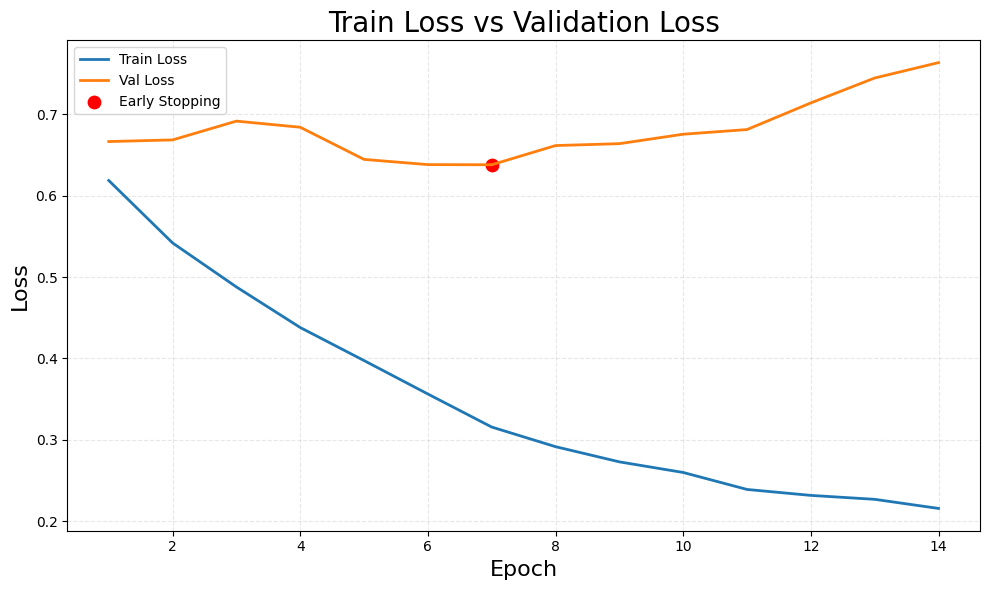

In [ ]:
# plot train loss e val loss

epochs = range(1, len(train_losses) + 1)
early_stop_epoch = 7
plt.figure(figsize=(10,6))

plt.plot(epochs, train_losses, label='Train Loss', linewidth=2)
plt.plot(epochs, val_losses, label='Val Loss', linewidth=2)

plt.scatter(
    early_stop_epoch,
    val_losses[early_stop_epoch - 1],   # gli indici partono da 0
    color='red',
    s=80,
    label='Early Stopping'
)

plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.title("Train Loss vs Validation Loss", fontsize = 20)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


Test Confusion Matrix:
[[2002  963]
 [ 487 1279]]


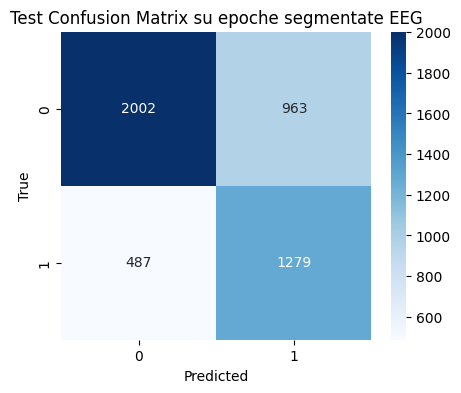

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # filtra solo le classi 0 e 1
        mask = (y_batch != 2)
        if mask.sum() == 0:  # se non ci sono esempi validi, salta
            continue

        X_batch_bin, y_batch_bin = X_batch[mask].to(device), y_batch[mask].to(device)
        outputs = model(X_batch_bin)

        # torch.max restituisce (valore massimo, indice della classe)
        # qui ci interessa solo l'indice della classe predetta
        _, preds = torch.max(outputs, 1)

        # Aggiungiamo le etichette vere e le predizioni alle liste Python
        # .cpu() → spostiamo su CPU
        # .numpy() → convertiamo in array NumPy
        # .extend() → aggiunge ogni elemento singolarmente alla lista

        y_true.extend(y_batch_bin.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# confusion matrix

cm_test = confusion_matrix(y_true, y_pred)

print(f"\nTest Confusion Matrix:\n{cm_test}")

# plot heatmap

plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix su epoche segmentate EEG")
plt.show()
